In [85]:
# from google.colab import drive
# drive.mount('/content/drive')

# 1. Thêm các thư viện cần thiết

In [86]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.signal import spectrogram
from scipy.interpolate import griddata

from skimage.transform import resize

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# 2. Chuẩn bị dữ liệu

In [88]:
# Nhập dữ liệu từ file
def load_data(data_path):
    X_train = np.load(f'{data_path}/A01T_X.npy')
    y_train = np.load(f'{data_path}/A01T_Y.npy')
    X_test = np.load(f'{data_path}/A01E_X.npy')
    y_test = np.load(f'{data_path}/A01E_Y.npy')

    for i in range(2, 10, 1):
        xt = np.load(f'{data_path}/A0{i}T_X.npy')
        yt = np.load(f'{data_path}/A0{i}T_Y.npy')
        xv = np.load(f'{data_path}/A0{i}E_X.npy')
        yv = np.load(f'{data_path}/A0{i}E_Y.npy')

        X_train = np.concatenate([X_train, xt])
        y_train = np.concatenate([y_train, yt])
        X_test = np.concatenate([X_test, xv])
        y_test = np.concatenate([y_test, yv])

    # X_train = torch.from_numpy(X_train)
    # X_test = torch.from_numpy(X_test)
    # y_train = torch.from_numpy(y_train)
    # y_test = torch.from_numpy(y_test)
    
    X = np.concatenate([X_train, X_test])
    y = np.concatenate([y_train, y_test])

    return X, y

In [89]:
data_path = 'data/bci-iv-2a'

X, y = load_data(data_path)

In [90]:
# Hàm tính năng lượng phổ
def compute_band_energy(signal, fs, band):
    freqs, _, Sxx = spectrogram(signal, fs=fs, nperseg=256)
    band_energy = Sxx[(freqs >= band[0]) & (freqs <= band[1]), :].sum(axis=0)
    return band_energy.mean()
    # return Sxx

# Chuyển đổi tín hiệu thành ảnh
def create_spatial_map(trial_data, fs, bands, output_size=(32, 32)):
    spatial_maps = []
    for band_name, band_range in bands.items():
        # Tính năng lượng phổ cho mỗi kênh
        band_energies = [compute_band_energy(trial_data[channel], fs, band_range) for channel in range(trial_data.shape[0])]

        # Nội suy để tạo bản đồ không gian 32x32
        spatial_map = np.stack(band_energies, axis=-1)
        spatial_map = resize(spatial_map, (output_size[0], output_size[1]), mode='reflect')
        
        # Chuẩn hóa
        min_val = np.min(spatial_map)
        max_val = np.max(spatial_map)
        spatial_map = (spatial_map - min_val) / (max_val - min_val)  
        spatial_map = (spatial_map * 255).astype(np.uint8)  # Chuyển đổi sang uint8

        spatial_maps.append(spatial_map)

    # Ghép thành 3 kênh RGB-like
    return np.stack(spatial_maps[:3], axis=0)  # Chỉ lấy 3 băng tần (Theta, Alpha, Beta)

# Áp dụng cho toàn bộ dữ liệu
def process_all_trials(X, fs, bands, output_size=(32, 32)):
    processed_data = []
    
    for trial in tqdm(X):
        processed_data.append(create_spatial_map(trial, fs, bands, output_size))
    
    return np.array(processed_data)

In [91]:
# # Các tham số
# fs = 256  # Tần số lấy mẫu
# bands = {"Theta": (4, 8), "Alpha": (8, 12), "Beta": (12, 30)}

# # Apply on X
# X_train = process_all_trials(X_train, fs, bands, output_size=(32, 32))
# X_test = process_all_trials(X_test, fs, bands, output_size=(32, 32))

In [92]:
def convert_to_feature_img_tensor(eeg_signal_tensor, img_size):
    imgg = []
    for i in range(eeg_signal_tensor.shape[1]):
        f, t, Sxx = spectrogram(eeg_signal_tensor[:, i], fs= 256, nperseg=3) # fs là tần số lấy mẫu
        imgg.append(Sxx)
        
    feature_map = np.stack(imgg, axis=-1)
    
    feature_map_resized = np.zeros((img_size, img_size, 3))  # Tạo tensor rỗng
    for i in range(3):  # Resize từng kênh
        feature_map_resized[:, :, i] = resize(
            feature_map[:, :, i], (img_size, img_size), mode='reflect'
        )
    min_val = np.min(feature_map_resized)
    max_val = np.max(feature_map_resized)
    feature_map_resized = (feature_map_resized - min_val)/(max_val - min_val)
    feature_map_resized = feature_map_resized*255
    return feature_map_resized # img_size x img_size x channel

In [93]:
X_processed = []
for trial in tqdm(X):
    X_processed.append(convert_to_feature_img_tensor(torch.Tensor(trial), 128))
X = np.array(X_processed)

100%|██████████| 5184/5184 [35:18<00:00,  2.45it/s]


In [94]:
X.shape

(5184, 128, 128, 3)

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [96]:
unique, counts = np.unique(y_train, return_counts=True)
print(unique, counts)

[0 1 2 3] [1014 1052 1039 1042]


In [97]:
class EEGSpectralDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Lấy ảnh và nhãn
        image = self.X[idx]
        label = self.y[idx]

        # Áp dụng biến đổi
        if self.transform:
            image = self.transform(image)

        return torch.tensor(image, dtype=torch.float32).permute(2, 0, 1), torch.tensor(label, dtype=torch.long)

In [98]:
# Train and test dataset
train_dataset = EEGSpectralDataset(X_train, y_train)
test_dataset = EEGSpectralDataset(X_test, y_test)

In [99]:
# Train and test loader
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [100]:
i, l = next(iter(train_loader))

In [101]:
i.shape, l.shape

(torch.Size([16, 3, 128, 128]), torch.Size([16]))

In [102]:
train_dataset[0][0].shape

torch.Size([3, 128, 128])

In [103]:
((train_dataset[0][0].permute(1, 2, 0) / 255)).dtype

torch.float32

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


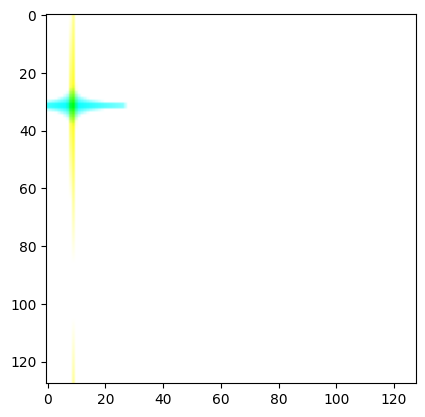

In [104]:
# Get the image data as a numpy array
img_array = (train_dataset[10][0].permute(1, 2, 0)).numpy()

# Display using matplotlib's imshow
plt.imshow(img_array)
plt.show()


# 3. Xây dựng mô hình

In [112]:
class Block(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size, stride=1, padding=1)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size, stride=1, padding=1)
        self.elu = nn.ELU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu(x)
        x = self.conv2(x)
        x = self.elu(x)
        x = self.maxpool(x)
        return x

class EEGCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(EEGCNN, self).__init__()
        self.blockcv1 = Block(input_channels, 32, 3)
        self.blockcv2 = Block(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.elu = nn.ELU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.blockcv1(x)
        x = self.blockcv2(x)
        x = self.conv3(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.elu(x)
        x = self.fc2(x)
        return x

In [113]:
model = EEGCNN(input_channels=3, num_classes=4)

# 4. Huấn luyện và đánh giá mô hình

## 4.1. Định nghĩa các hàm chức năng

In [114]:
def evaluate_model(model, test_loader, criterion, device=None):
    if device is not None:
        model.to(device)

    model.eval()
    running_loss = 0.0

    true_labels = []
    predicted_labels = []

    for images, labels in tqdm(test_loader, unit='batch', desc='Evaluating'):
        if device is not None:
            images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        predicted = torch.argmax(outputs, dim=-1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(test_loader)
    accuracy = accuracy_score(true_labels, predicted_labels)

    labels = list(range(4))
    names = ['Left Hand', 'Right Hand', 'Foot', 'Tongue']
    classification_rep = classification_report(true_labels, predicted_labels, labels=labels, target_names=names, zero_division=0)

    print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}\n\tClassification Report:\n{classification_rep}')

    return epoch_loss, accuracy

In [115]:
def train_model(model, train_loader, test_loader, criterion, optimizer, device=None, epochs=10):
    if device is not None:
        model.to(device)
    model.train()

    train_losses = []
    train_acc = []
    test_losses = []
    test_acc = []

    for epoch in range(epochs):
        running_loss = 0.0

        true_labels = []
        predicted_labels = []

        for images, labels in tqdm(train_loader, unit='batch', desc=f'Training epoch [{epoch+1}/{epochs}]'):
            if device is not None:
                images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            predicted = torch.argmax(outputs, dim=-1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        accuracy = accuracy_score(true_labels, predicted_labels)
        train_acc.append(accuracy)
        print(f'\t---> Loss: {epoch_loss:.4f}\n\t---> Accuracy: {accuracy:.4f}')

        test_loss, test_ac = evaluate_model(model, test_loader, criterion, device)
        test_losses.append(test_loss)
        test_acc.append(test_ac)
    print("==========================================================================")
    
    return train_losses, train_acc, test_losses, test_acc

## 4.2. Huấn luyện và đánh giá

In [116]:
lr = 0.003
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [117]:
train_losses, train_acc, test_losses, test_acc = train_model(model, train_loader, test_loader, criterion, optimizer, device=device, epochs=10)

Training epoch [1/10]: 100%|██████████| 260/260 [00:54<00:00,  4.76batch/s]


	---> Loss: 6.0843
	---> Accuracy: 0.2431


Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.15batch/s]


	---> Loss: 1.3910
	---> Accuracy: 0.2353
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.24      1.00      0.38       244
        Foot       0.00      0.00      0.00       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.24      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.24      0.09      1037



Training epoch [2/10]: 100%|██████████| 260/260 [01:00<00:00,  4.28batch/s]


	---> Loss: 1.3892
	---> Accuracy: 0.2472


Evaluating: 100%|██████████| 65/65 [00:15<00:00,  4.08batch/s]


	---> Loss: 1.3919
	---> Accuracy: 0.2353
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.24      1.00      0.38       244
        Foot       0.00      0.00      0.00       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.24      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.24      0.09      1037



Training epoch [3/10]: 100%|██████████| 260/260 [01:01<00:00,  4.21batch/s]


	---> Loss: 1.3909
	---> Accuracy: 0.2503


Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.43batch/s]


	---> Loss: 1.3953
	---> Accuracy: 0.2478
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.25      1.00      0.40       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.25      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.25      0.10      1037



Training epoch [4/10]: 100%|██████████| 260/260 [00:57<00:00,  4.53batch/s]


	---> Loss: 1.3912
	---> Accuracy: 0.2462


Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.41batch/s]


	---> Loss: 1.3920
	---> Accuracy: 0.2478
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.25      1.00      0.40       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.25      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.25      0.10      1037



Training epoch [5/10]: 100%|██████████| 260/260 [01:08<00:00,  3.80batch/s]


	---> Loss: 1.3906
	---> Accuracy: 0.2450


Evaluating: 100%|██████████| 65/65 [00:14<00:00,  4.61batch/s]


	---> Loss: 1.3872
	---> Accuracy: 0.2478
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.25      1.00      0.40       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.25      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.25      0.10      1037



Training epoch [6/10]: 100%|██████████| 260/260 [01:01<00:00,  4.22batch/s]


	---> Loss: 1.3922
	---> Accuracy: 0.2607


Evaluating: 100%|██████████| 65/65 [00:18<00:00,  3.58batch/s]


	---> Loss: 1.3962
	---> Accuracy: 0.2449
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.00      0.00      0.00       257
      Tongue       0.24      1.00      0.39       254

    accuracy                           0.24      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.24      0.10      1037



Training epoch [7/10]: 100%|██████████| 260/260 [00:53<00:00,  4.91batch/s]


	---> Loss: 1.3911
	---> Accuracy: 0.2440


Evaluating: 100%|██████████| 65/65 [00:09<00:00,  7.13batch/s]


	---> Loss: 1.3877
	---> Accuracy: 0.2719
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.27      1.00      0.43       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.00      0.00      0.00       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.27      1037
   macro avg       0.07      0.25      0.11      1037
weighted avg       0.07      0.27      0.12      1037



Training epoch [8/10]: 100%|██████████| 260/260 [00:45<00:00,  5.70batch/s]


	---> Loss: 1.3950
	---> Accuracy: 0.2558


Evaluating: 100%|██████████| 65/65 [00:10<00:00,  6.35batch/s]


	---> Loss: 1.3997
	---> Accuracy: 0.2478
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.25      1.00      0.40       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.25      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.25      0.10      1037



Training epoch [9/10]: 100%|██████████| 260/260 [00:48<00:00,  5.35batch/s]


	---> Loss: 1.3956
	---> Accuracy: 0.2633


Evaluating: 100%|██████████| 65/65 [00:09<00:00,  6.74batch/s]


	---> Loss: 1.3939
	---> Accuracy: 0.2353
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.24      1.00      0.38       244
        Foot       0.00      0.00      0.00       257
      Tongue       0.00      0.00      0.00       254

    accuracy                           0.24      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.24      0.09      1037



Training epoch [10/10]: 100%|██████████| 260/260 [00:58<00:00,  4.45batch/s]


	---> Loss: 1.3945
	---> Accuracy: 0.2660


Evaluating: 100%|██████████| 65/65 [00:12<00:00,  5.00batch/s]

	---> Loss: 1.3935
	---> Accuracy: 0.2449
	Classification Report:
              precision    recall  f1-score   support

   Left Hand       0.00      0.00      0.00       282
  Right Hand       0.00      0.00      0.00       244
        Foot       0.00      0.00      0.00       257
      Tongue       0.24      1.00      0.39       254

    accuracy                           0.24      1037
   macro avg       0.06      0.25      0.10      1037
weighted avg       0.06      0.24      0.10      1037



## 4.3. Visualize results

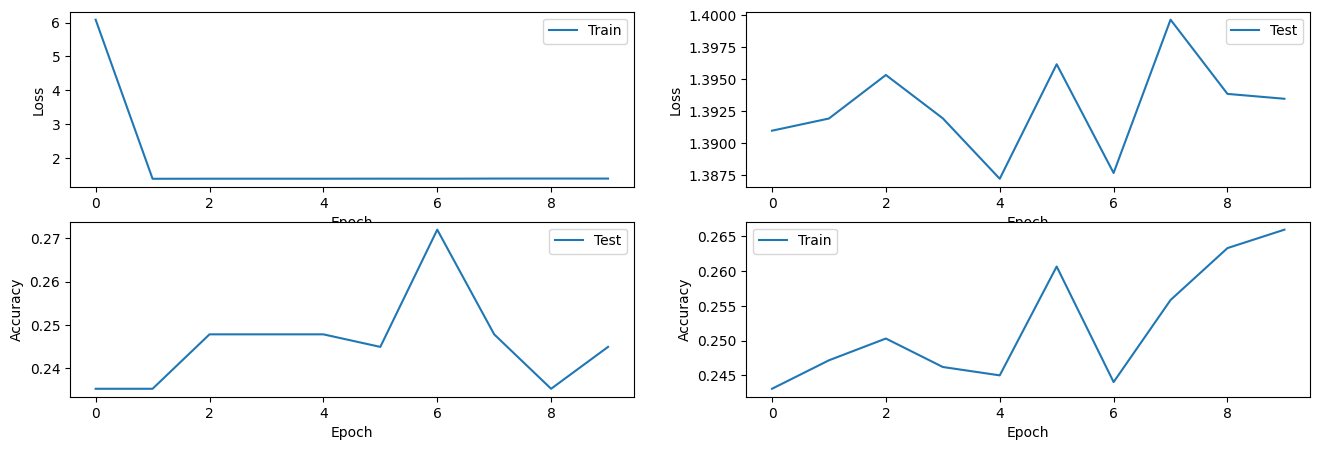

In [118]:
plt.figure(figsize=(16, 5))
plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(test_acc, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(train_acc, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()